# Plot nucleolous object features for CX5461 and unperturbed

In [1]:
from campa.tl import Experiment, FeatureExtractor
from campa_ana.constants import SOURCE_DIR
from pathlib import Path
from campa.pl import hex2rgb
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import anndata as ad

Reading config from [PosixPath('/Users/hannah.spitzer/.config/campa/campa.ini'), PosixPath('/Users/hannah.spitzer/projects/pelkmans/software_new/campa_ana/figures/campa.ini'), PosixPath('/Users/hannah.spitzer/projects/pelkmans/software_new/campa/config.ini')]


In [ ]:
fig_dir = Path(SOURCE_DIR)/'figures'/'fig4'
os.makedirs(str(fig_dir), exist_ok=True)

In [2]:
def add_perturbation_plot(adata):
    # create perturbation_plot column from perturbation_duration column
    p = np.array(adata.obs['perturbation_duration'])
    p[p == 'AZD4573-120'] = 'AZD4573 (2.5h)'
    p[p == 'AZD4573-30'] = 'AZD4573 (1h)'
    p[p == 'CX5461-120'] = 'CX5461 (2.5h)'
    p[p == 'Meayamycin-720'] = 'Meayamycin (12.5h)'
    p[p == 'TSA-30'] = 'TSA (1h)'
    p[p == 'Triptolide-120'] = 'Triptolide (2.5h)'
    p[np.in1d(p, ['DMSO-120', 'DMSO-720', 'normal'])] = 'unperturbed'
    adata.obs['perturbation_plot'] = p
    adata.obs['perturbation_plot'] = adata.obs['perturbation_plot'].astype('category')
    print(adata.obs['perturbation_plot'].cat.categories)
    adata.uns['perturbation_plot_colors'] = ['#377eb8', '#984ea3', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#999999']  #https://gist.github.com/thriveth/8560036


In [3]:
exp = Experiment.from_dir('VAE_all/CondVAE_pert-CC')
extrs = {data_dir: FeatureExtractor.from_adata(os.path.join(exp.full_path, 'aggregated/full_data', data_dir, 'features_annotation.h5ad')) 
    for data_dir in exp.data_params['data_dirs']}

In [4]:
adata = ad.concat([extr.adata for extr in extrs.values()], index_unique='-', uns_merge='same')
add_perturbation_plot(adata)

Index(['AZD4573 (1h)', 'AZD4573 (2.5h)', 'CX5461 (2.5h)', 'Meayamycin (12.5h)',
       'TSA (1h)', 'Triptolide (2.5h)', 'unperturbed'],
      dtype='object')


In [5]:
cats = ['unperturbed', 'CX5461 (2.5h)']
colors = [adata.uns['perturbation_plot_colors'][list(adata.obs['perturbation_plot'].cat.categories).index(c)] for c in cats]
colors = np.array(list(map(hex2rgb, colors)))/256.

Text(0, 0.5, 'Area (% of Nucleolus)')

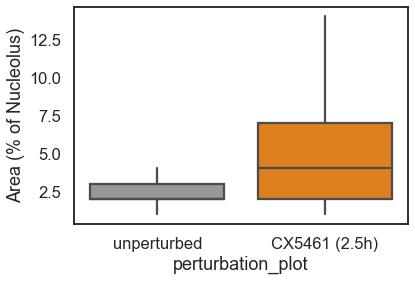

In [17]:
sns.set_style('white')
sns.set_context('talk')

df = adata.obsm['size'].copy()
df['perturbation_plot'] = adata.obs['perturbation_plot']
df['nucleolus_fraction'] = df['Nucleolus'] / df['all'] * 100

# object count
#ax = axes[0][0]
df = adata.obsm['object_count'].copy()
df['perturbation_plot'] = adata.obs['perturbation_plot']
g = sns.boxplot(data=df, y='Nucleolus', x='perturbation_plot', order=cats, palette=colors, showfliers=False, showcaps=False)# ax=ax)
g.set_ylabel('Area (% of Nucleolus)')

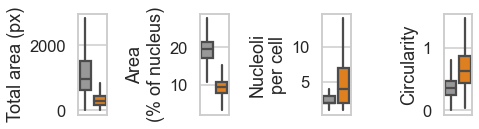

In [61]:
sns.set_style('whitegrid')
sns.set_context('talk')

fig, axes = plt.subplots(1,4, figsize=(7,2), sharex=True, squeeze=False)
# total area 
ax = axes[0][0]
df = adata.obsm['object_area_mean'].copy()
df['perturbation_plot'] = adata.obs['perturbation_plot']
sns.boxplot(data=df, y='Nucleolus', x='perturbation_plot', order=cats, palette=colors, showfliers=False, showcaps=False, ax=ax)
ax.set_ylabel('Total area (px)')

# relative area
ax = axes[0][1]
df = adata.obsm['size'].copy()
df['perturbation_plot'] = adata.obs['perturbation_plot']
df['nucleolus_fraction'] = df['Nucleolus'] / df['all'] * 100
g = sns.boxplot(data=df, y='nucleolus_fraction', x='perturbation_plot', order=cats, palette=colors, showfliers=False, showcaps=False, ax=ax)
g.set_ylabel('Area\n(% of nucleus)')

# object count
ax = axes[0][2]
df = adata.obsm['object_count'].copy()
df['perturbation_plot'] = adata.obs['perturbation_plot']
sns.boxplot(data=df, y='Nucleolus', x='perturbation_plot', order=cats, palette=colors, showfliers=False, showcaps=False, ax=ax)
ax.set_ylabel('Nucleoli\nper cell')

# circularity
ax = axes[0][3]
df = adata.obsm['object_circularity_median'].copy()
df['perturbation_plot'] = adata.obs['perturbation_plot']
sns.boxplot(data=df, y='Nucleolus', x='perturbation_plot', order=cats, palette=colors, showfliers=False, showcaps=False, ax=ax)
ax.set_ylabel('Circularity')


for ax in axes.flat:
    ax.set_xlabel('')
    ax.set_xticklabels([])
    #ax.set_xticklabels(cats, rotation = 90)
plt.tight_layout()
plt.savefig(fig_dir/'object_features_CX5461.png', dpi=300)
